# COGS 108 - Final Project 

# Overview

We were curious about the rating system in the Google Play Store works, since smartphones take up a big chunk of most people’s time. We decided to see if more downloads of an app correlates with the rating that the app gets. After cleaning and analyzing our dataset, we concluded that there is not necessarily a positive correlation between the popularity(number of installs) of an application and its rating. This project did lead to the fact that more downloads leads to a more accurate rating of an application, since more people have rated it.


# Names

- Akshay Rao
- David Zheng
- Hao Luo
- Kevin Wu
- Nikita Hegde
- Tianhui hu

# Group Members IDs

- A12170395
- A13424042
- A14896221
- A12830930
- A12890202
- A92108202

# Research Question

Does popularity of Android applications have a positive correlation to higher ratings in Google Play Store? Popularity of apps is measured by the total amount of downloads since the app was released.

## Background and Prior Work

Why is this question of interest to your group?
If we step back from our daily routine and take time to audit where we spend most of our attention, it’s arguably on our smartphones. The medium of the smartphone is applications. Due to this increasing demand, app creators are pressured to preserve high ratings, as higher ratings means more downloads, which in turn leads to more money in their pockets. As we were discussing it and seeing as how most of us were intrigued by it, we decided to do a data science project exploring the correlation between number of downloads and the rating of the application.
What background information led to your hypothesis?
Mostly common sense went into our hypothesis. To break it down in graphic specificity we thought that since more people install the application, it is an application that benefits many people. The fact that it benefits people means that they regard it in a positive light, since it offers some sort of value to them. Since they perceive value in the application they are more likely to rate it higher on the Google Play Store.
Why is this important?
This question is important because people who are app developers are going to want to know certain data on ratings of apps and the correlation of that with downloads.
How do references relate to our project?
The first reference is an article that explains how App Store ratings impact downloads. This would be an important study to do after we do our project because it explores the opposite of our project. In addition, there is causality involved in this article, and that is different than ours. We chose to focus on correlation, which doesn’t imply causation.

References (include links):
1) How App Store Ratings Impact Downloads (Infographic)
https://www.adweek.com/digital/how-app-store-ratings-impact-downloads-infographic/


# Hypothesis


We hypothesize that there is a positive correlation between average rating and the total number of installations for Android Applications. We predict that the more downloads there are, the higher the ratings would be because people may have a biased attitude toward already popular apps.

# Dataset(s)

Link to the dataset: https://www.kaggle.com/lava18/google-play-store-apps?fbclid=IwAR0ynkTjJl92etJH3FiytTpChyziBCN92xNtqqyDeq2LD7cPNh-KC6a1fWg
Number of observations: 10.8k

Description: 
The data set is Web scraped data of 10k Play Store apps for analysing the Android market. The data set contains 10.8k observations, and each entry contains the following 13 features of a particular app:

App: Application name

Category: Category the app belongs to

Rating: Overall user rating of the app (as when scraped)

Reviews: Number of user reviews for the app (as when scraped)

Size: Size of the app (as when scraped)

Installs: Number of user downloads/installs for the app (as when scraped)

Type: Paid or Free

Price: Price of the app (as when scraped)

Content Rating: Age group the app is targeted at - Children / Mature 21+ / Adult

Genres: An app can belong to multiple genres (apart from its main category). For eg, a musical family game will belong to Music, Game, Family genres.

Last Updated: Date when the app was last updated on Play Store (as when scraped)

Current Ver: Current version of the app available on Play Store (as when scraped)

Android Ver: Min required Android version (as when scraped)


# Setup

In [73]:
# Imports 
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import patsy
import statsmodels.api as sm
import scipy.stats as stats
import warnings
from scipy.stats import ttest_ind, chisquare, normaltest
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split


# Data Cleaning

Describe your data cleaning steps here:

We first read data from cvs file to data frame. Then we drop unrelevent info and null values. 

In [74]:
# Read data from the cvs file
df = pd.read_csv( 'googleplaystore.csv' )

df = df.drop(columns="Current Ver")
df = df.drop(columns="Android Ver")
df.dropna(inplace=True)

df.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018"
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018"
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018"
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018"
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018"


We filter by "Content Rating" column and keeps applications that are available to everyone. 

In [75]:
df = df[(df['Content Rating'] == "Everyone")].copy()

Function to pre-process last updated date column. Convert the string to integers, which represent last updated year.

In [76]:
def standardize_last_updated_year(string):
    
    string = string.strip()
    
    if "2018" in string:
        output = 2018
    elif "2017" in string:
        output = 2017
    elif "2016" in string:
        output = 2016
    elif "2015" in string:
        output = 2015
    elif "2014" in string:
        output = 2014
    elif "2013" in string:
        output = 2013
    elif "2012" in string:
        output = 2012
    elif "2011" in string:
        output = 2011
    elif "2010" in string:
        output = 2010
    # Otherwise, if uncaught - write 0
    else:
        output = string
    
    return output

In [77]:
df["Last Updated"] = df["Last Updated"].apply(standardize_last_updated_year)

Convert review column to integers for future regression tests.

In [78]:
df['Reviews'] = df['Reviews'].astype(np.int64)

In [79]:
# Converts Mb and kb values to bytes and removes the unit of memory
def standardize_size(str_in):
    if 'k' in str_in:
        try:
            output = round(float(str_in[:-1]) * 1000)
        except:
            output = 0.0
            
    elif 'M' in str_in:
        try:
            output = round(float(str_in[:-1]) * 1000000)
        except:
            output =  0.0
            
    else:
            output = 0.0
            
    return output

In [80]:
df['Size'] = df['Size'].apply(standardize_size)

Convert install column from string to int for future regression tests.

In [81]:
# Remove '+' and ',' symbols from Intalls and cast to int
def standardize_installs(str_in):
    output = int(str_in.replace('+' ,'').replace(',',''))
    return output

In [82]:
df['Installs'] = df['Installs'].apply(standardize_installs)

In [83]:
# Cast Price as a float without the '$'
def standardize_price(str_in):
    output = float(str_in.replace('$', ''))
    return output

In [84]:
df['Price'] = df['Price'].apply(standardize_price)

Display cleaned dataframe

In [85]:
df.head(5)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19000000.0,10000,Free,0.0,Everyone,Art & Design,2018
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14000000.0,500000,Free,0.0,Everyone,Art & Design;Pretend Play,2018
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8700000.0,5000000,Free,0.0,Everyone,Art & Design,2018
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2800000.0,100000,Free,0.0,Everyone,Art & Design;Creativity,2018
5,Paper flowers instructions,ART_AND_DESIGN,4.4,167,5600000.0,50000,Free,0.0,Everyone,Art & Design,2017


# Data Analysis & Results

To get a general over view the data set, we get the max, min, average, and media of the rating. 

In [86]:
## Overview of the data 
df["Rating"].max()

5.0

In [87]:
df["Rating"].min()

1.0

In [88]:
df["Rating"].mean()

4.186374663072782

In [89]:
df["Rating"].median()

4.3

Check for normality of data

In [90]:
def check_p_val(p_val, alpha):
    if p_val < alpha:
        print('We have evidence to reject the null hypothesis.')
        print('The data is not normally distributed.')
    else:
        print('We do not have evidence to reject the null hypothesis.')
        print('The data is normally distributed.')

In [91]:
ratings = df['Rating'].values
st_ratings, p_ratings = normaltest(ratings)
print("test statistic:", st_ratings, "p-value:", p_ratings)
check_p_val(p_ratings, 0.01)

test statistic: 2871.7869107159167 p-value: 0.0
We have evidence to reject the null hypothesis.
The data is not normally distributed.


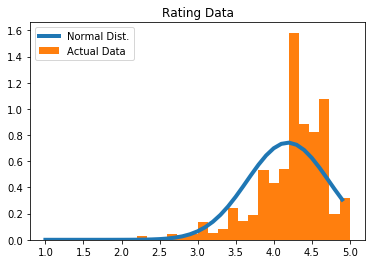

In [92]:
xs = np.arange(ratings.min(), ratings.max(), 0.1)
fit = stats.norm.pdf(xs, np.mean(ratings), np.std(ratings))
plt.plot(xs, fit, label='Normal Dist.', lw=4)
plt.hist(ratings, 30,  density=True, label='Actual Data');
plt.title('Rating Data')
plt.legend();

In [93]:
reviews = df['Reviews'].values
st_reviews, p_reviews = normaltest(reviews)
print("test statistic:", st_reviews, "p-value:", p_reviews)
check_p_val(p_reviews, 0.01)

test statistic: 15584.97433551716 p-value: 0.0
We have evidence to reject the null hypothesis.
The data is not normally distributed.


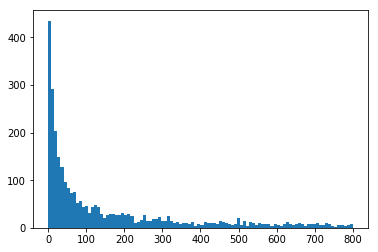

In [94]:
plt.hist(df['Reviews'].values, bins=100, range=(0, 800))
plt.show()

In [95]:
intalls = df['Installs'].values
st_installs, p_installs = normaltest(ratings)
print("test statistic:", st_installs, "p-value:", p_installs)
check_p_val(p_installs, 0.01)

test statistic: 2871.7869107159167 p-value: 0.0
We have evidence to reject the null hypothesis.
The data is not normally distributed.


It is clear that the data for ratings, reviews and installs are all not normal so tests that assume normally distributed data will not be accurate.

### Visualization

First by using the scatter_matrx method, we plotting the whole dataframe.
Since every attributes have multiple valules, we choose the scatter plot to show the relations.

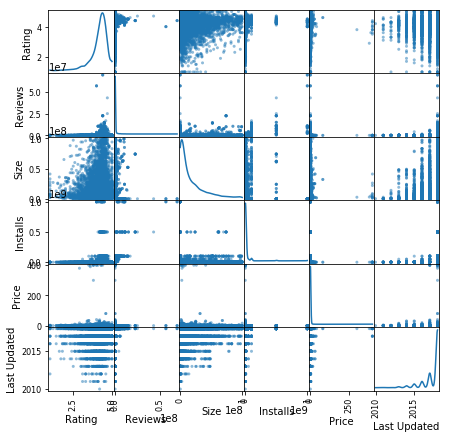

In [96]:
fig =  pd.plotting.scatter_matrix(df, figsize = (7,7), diagonal='kde')

From the plot above, we can see there is a positive correlation between rating and installs. According to it the more installs the higher the rating will be .
We can get a feel from the plot, last updated time, size and reviews have impacts on ratings. A larger app can often get a higher rating while apps that haven't been updated for a while are unlikely to get a lower ratings.

And there are also some other correlations, such as, the later the apps updated the bigger size of the apps will be.

Text(0, 0.5, 'Installs(1000000)')

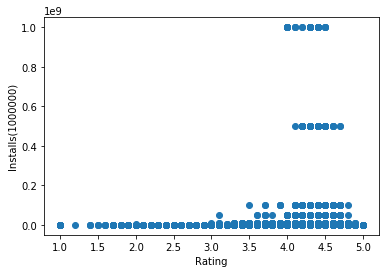

In [97]:
plt.scatter(df['Rating'], df['Installs'])
plt.xlabel('Rating')
plt.ylabel('Installs(1000000)')

Text(0, 0.5, 'Last Updated(year)')

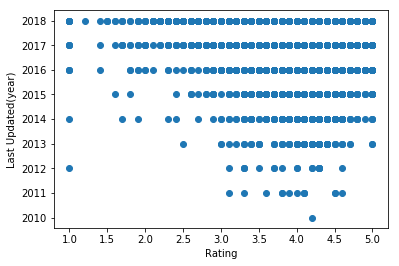

In [98]:
plt.scatter(df['Rating'], df['Last Updated'])
plt.xlabel('Rating')
plt.ylabel('Last Updated(year)')

As shown in the plot, the higher the rating is the higher the installations will be. However the positive correlation seems not clear enough when comparing to other factors. 

### Linear model

In [99]:

outcome_1, predictors_1 = patsy.dmatrices("Rating ~ Installs", df)
mod_1 = sm.OLS(outcome_1, predictors_1)
res_1 = mod_1.fit()
print(res_1.summary())


                            OLS Regression Results                            
Dep. Variable:                 Rating   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     19.53
Date:                Wed, 12 Jun 2019   Prob (F-statistic):           1.00e-05
Time:                        17:20:50   Log-Likelihood:                -5910.0
No. Observations:                7420   AIC:                         1.182e+04
Df Residuals:                    7418   BIC:                         1.184e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.1812      0.006    659.570      0.0

Above we have created a linear model to predict rating from installs (using df as data).
We used patsy.dmatrices to create the design matrices, calling the outputs outcome_1, predictors_1.
We then created an OLS model (sm.OLS) using outcome_1 and predictors_1. Call it mod_1.
Finally we fitted the model, assigning it to res_1.
Based on the R-squared (using alpha value of 0.01), we can safely conclude that installs do have a positive correlation to the rating of the phone apps.

In [100]:
pv = pd.pivot_table(df, values='Rating', index=['Installs', 'Reviews'])
pv

Rating
Installs   Reviews           
1          2         5.000000
           4         5.000000
5          1         5.000000
           2         4.125000
           4         5.000000
           5         5.000000
           7         5.000000
10         1         4.678571
           2         4.500000
           3         4.733333
           4         4.233333
           5         4.900000
           6         4.800000
           7         5.000000
           8         4.250000
           9         5.000000
           10        4.800000
           11        5.000000
50         1         3.125000
           2         4.444444
           3         4.740000
           4         4.900000
           5         4.244444
           6         4.566667
           7         5.000000
           8         5.000000
           9         4.700000
           12        4.600000
           14        5.000000
           15        4.800000
...                       ...
500000000  24900999  4.700000
           42916526  4.700000
1000000000 2129689   4.200000
           2129707   4.200000
           2728941   4.400000
           2731171   4.400000
           2731211   4.400000
           3419249   4.000000
           3419433   4.000000
           3419464   4.000000
           3419513   4.000000
           4604324   4.300000
           4604483   4.300000
           8021623   4.400000
           8033493   4.400000
           9231613   4.300000
           9235155   4.300000
           9235373   4.300000
           9642112   4.300000
           9642995   4.300000
           9643041   4.300000
           10484169  4.100000
           10847682  4.500000
           10858538  4.500000
           10858556  4.500000
           10859051  4.500000
           56642847  4.000000
           56646578  4.000000
           69109672  4.400000
           69119316  4.400000

[5359 rows x 1 columns]

### Multivariate regression: 

In order to eliminate the impact of number of reviews, we use Multivariable regression with three variables Installs, Reviews, and Ratings. 

We create a linear model to predict ratings from both Installs and Reviews: 

We use `patsy.dmatrices` to create the design matrices, calling the outputs `outcome_2`, `predictors_2`

We create an OLS model (`sm.OLS`) using `outcome_2` and `predictors_2`, and call it as `mod_2`.

We fit the model, by assigning it to `res_2`.


In [101]:
outcome_2, predictors_2 = patsy.dmatrices( 'Rating ~ Installs+ Reviews', df )
mod_2 = sm.OLS(outcome_2, predictors_2)
res_2 = mod_2.fit()

Assertion statement to make sure the model is built successfully. 

In [102]:
assert isinstance(outcome_2, patsy.design_info.DesignMatrix)
assert isinstance(predictors_2, patsy.design_info.DesignMatrix)
assert isinstance(mod_2, sm.regression.linear_model.OLS)
assert isinstance(res_2, sm.regression.linear_model.RegressionResultsWrapper)

Print the result from regression tests. 

In [103]:
# Print out the results 
print(res_2.summary())

                            OLS Regression Results                            
Dep. Variable:                 Rating   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     15.11
Date:                Wed, 12 Jun 2019   Prob (F-statistic):           2.82e-07
Time:                        17:20:57   Log-Likelihood:                -5904.7
No. Observations:                7420   AIC:                         1.182e+04
Df Residuals:                    7417   BIC:                         1.184e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.1802      0.006    658.970      0.0

Based on the model you we above (using alpha value of 0.01), we exame the p-values. 

According the OLS Regression Results above. The p-value associated with Installs is 0.186, while the p-value associtaed with Reviews is 0.001. 

We can safely conclude that Reviews do have a positive correlation to the rating of the phone apps, while Installs do not.

### Regression Model

- A Random Forest is an ensemble technique capable of performing both regression and classification tasks with the use of multiple decision trees and a technique called Bootstrap Aggregation
- We used Skit-Learn's RandomForestRegressor as our model because of its high accuracy 
- Before using the model we must ensure all the data is in numerical format

In [104]:
#before using regression model convert strings to numbers
warnings.filterwarnings('ignore')
encoder = LabelEncoder()
df["Content RatingNum"] = encoder.fit_transform(df["Content Rating"])
df['App'] = encoder.fit_transform(df['App'])
df['Genres'] = encoder.fit_transform(df['Genres'])
df['Type'] = pd.get_dummies(df['Type'])
df["CategoryNum"] = encoder.fit_transform(df["Category"])
df['Reviews'] = pd.to_numeric(df['Reviews'])
df['Price'] = pd.to_numeric(df['Price'])
df['Installs'] = pd.to_numeric(df['Installs'])
df = df[pd.notnull(df['Last Updated'])]

In [105]:
df.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Content RatingNum,CategoryNum
0,4720,ART_AND_DESIGN,4.1,159,19000000.0,10000,1,0.0,Everyone,9,2018,0,0
1,1799,ART_AND_DESIGN,3.9,967,14000000.0,500000,1,0.0,Everyone,11,2018,0,0
2,5916,ART_AND_DESIGN,4.7,87510,8700000.0,5000000,1,0.0,Everyone,9,2018,0,0
4,4773,ART_AND_DESIGN,4.3,967,2800000.0,100000,1,0.0,Everyone,10,2018,0,0
5,4658,ART_AND_DESIGN,4.4,167,5600000.0,50000,1,0.0,Everyone,9,2017,0,0


- We will select the depedent variables that will predict the variable Rating
- Following the 80/20 rule split the data into a training set(80% of the data) and test set(20% of the data)

In [106]:
#select features used in model 
features = ['CategoryNum','Reviews', 'Size', 'Installs', 'Type', 'Price', 'Content RatingNum']
X = df[features]
Y = df['Rating']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20)

- The most important parameter of the RandomForestRegressor class is the n_estimators parameter. This parameter defines the number of trees in the random forest.
- We create many RandomForestRegressors and evaluate their performance using mean squared error between the predicted and actual values.

In [107]:
#create model using a range of different estimators 
model = RandomForestRegressor(n_jobs=-1)
num = [300,320,330,350,370,390,410,430,450,470,490]
trainScore= []
testScore = []
for i in num:
    model.set_params(n_estimators = i)
    model.fit(X_train, Y_train)
    y_train_pred= model.predict(X_train)
    y_test_pred = model.predict(X_test)
    trainScore.append(mean_squared_error(Y_train, y_train_pred))
    testScore.append(mean_squared_error(Y_test, y_test_pred))

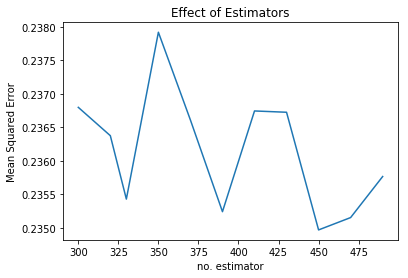

In [108]:
#plot the effect of the estimators based on the model mean squared error
plt.title("Effect of Estimators")
plt.xlabel("no. estimator")
plt.ylabel("Mean Squared Error")
plt.plot(num, testScore)

- Given the above graph the mean squared error ranges from about 0.2550 to 0.2580
- The mean squared error measures how close the predicted values are to the actual values 
- The smaller the means squared error, the closer we are to finding the line of best fit. 

- We now create a final RandomForestRegressor with the n_estimators set to 415

In [109]:
model2 = RandomForestRegressor(n_jobs=-1,n_estimators = 415, oob_score=True)
model2.fit(X_train, Y_train)
y_pred = model2.predict(X_test)

- The out of bag score, which measures the prediction error, is quite low indicating that the features chosen may not be the best features to predict the rating of an app 

In [110]:
model2.oob_score_

0.0907201219114585

- Even though our model may not be the most accurate we can use the feature importance of the model to discover which variables are the most relevant in predicting the target variable 'Rating'

In [111]:
feature_importances = model2.feature_importances_
feature_importances

array([0.16950663, 0.38627276, 0.29155913, 0.11191764, 0.00584621,
       0.03489764, 0.        ])

<BarContainer object of 7 artists>

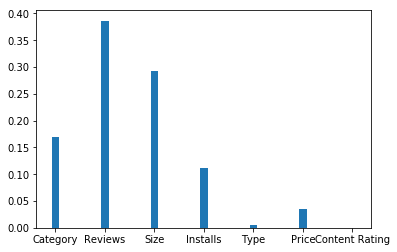

In [112]:
#plot the feature importance
featureName = ['Category','Reviews', 'Size', 'Installs', 'Type', 'Price', 'Content Rating']
plt.bar(featureName, feature_importances,.15)

- Given the graph above we can see that 'Reviews' and not 'Installs' is the most relevant variable out of the ones we have in predicting the app Rating. This is consistent with our earlier results from the multivaritate regression that Reviews are more important than Installs to determine the Rating.

In [113]:
diff = Y_test - y_test_pred
predicted = pd.DataFrame(np.c_[ Y_test, y_test_pred,diff])
predicted.columns = ['actual','predicted','difference']
predicted[0:20]

,actual,predicted,difference
0,4.7,4.430816,0.269184
1,4.3,4.409796,-0.109796
2,3.8,4.064490,-0.264490
3,4.4,4.667347,-0.267347
4,4.5,4.478163,0.021837
5,4.4,4.147143,0.252857
6,4.3,4.199898,0.100102
7,4.2,4.048776,0.151224
8,3.5,4.460000,-0.960000
9,3.7,3.952245,-0.252245


- As expected given our low model score, our predicted values differ significantly from the actual values.

# Ethics & Privacy

We found this data set on Kaggle https://www.kaggle.com/datasets, a open source data set website. We read through the terms and condition and made sure that we have permission to use this data for this purpose.Since this data does not involve individuals’ data, there is not much concern regarding the privacy of the datasets we are dealing with. One privacy concern is that app creators may not want others knowing the amount of downloads or ratings their app has. We will not release all name of app that have a low average rating, in order to avoid potential negative impacts on those applications. 

There are biases in our Dataset. For example, there are 10k apps used in our dataset. There may be a host of other apps that if we chose to analyze would give us a different conclusion. Maybe in another dataset of 10k apps, more downloads correlates with a higher rating.The issue with our data set is that it only contain 10k entries. It does not contain all the apps in Google Play Store. 

We handle this issue by acknowledge the facts that it does not contain every app in Google Play Store. Those sample we have may not represent all the application. With the potential bias in mind, we are more careful about drawing a conclusion. All the analysis and conclusion we have might not suitable for the all the apps. 


# Conclusion & Discussion

In order to perform data analysis on the data set, some preprocessing and data cleaning was required. However, some of this preprocessing could have affected our findings and results of our analysis. Dropping NaN values from the dataset could have skewed the dataset. In addition, while the number of reviews in the data was simply an integer value, the number of installs was an estimate with different cutoff thresholds which meant that it was not as specific in comparison to app ratings or number of reviews. 
In terms of normality, it is clear for our analysis that both the distribution of ratings as well as the distribution of reviews and installs were non normal and could therefore affect the accuracy of inference as a result. 


The dataset we got is all paired numerical data. And the dependent variable has multiple values for each value of an independent variable. Therefore we chose the scatter plot to show the relations among all the attributes. After showing the scatter plots, it turns out that, there is a positive correlation between rating and installs. However, a positive correlation is not very clear. Additionally, according to the plots between rating and other attributes, we can tell size, last updated time and reviews all have impacts on ratings. Although the number of installation alone is not enough to determine the rating, consider other factors together can lead to a better prediction.


Above we have also created a linear OLS model to predict rating from installs (using df as data). We have a total sample of 7420 different apps so it’s sufficient. We used patsy.dmatrices to create the design matrices, calling the outputs outcome_1, predictors_1. We then created an OLS model (sm.OLS) using outcome_1 and predictors_1. Call it mod_1. Finally, we fitted the model, assigning it to res_1.  Based on the model, F-statistic is 24.69, Prob (F-statistic) is 1.78e-80 and Log-Likelihood is -5703.4. Based on the R-squared value 0.057 (using alpha value of 0.01) and adjusted R-squared value 0.054, we can safely conclude that installs do have a positive correlation to the rating of the phone apps.


Even though, from the Linear Model Based on the R-squared (using alpha value of 0.01), we can safely conclude that installs do have a positive correlation to the rating of the phone apps. The conclusion is somewhat biased because we only consider the two factors "Installs" and "Rating". However, the correlation might come from some other factors like "Reviews". Therefore, we conducted Multivariable Regression Test to verify. From the Multivariable Regression Tests Results, and analyzing the p-values, we safely arrived the conclusion that Reviews do have a positive correlation to the rating of the phone apps, while Installs do not. From the different test results from different regression tests, we learned that to arrive a more well-rounded conclusion, we should take multiple factors into consideration. 

One of the pitfalls of our hypothesis that was evident after looking at the dataset was that even though more downloads may not lead to a higher rating, it leads to a more impactful rating. For example, if an app has 1 download and that person gives it a 5 star rating, it is less trustworthy than if 500,000 people have downloaded it and given it a 4.5 rating. Even though the rating is less for the more downloaded app, it is more trustworthy. Also, we probably should have focused more on causality than correlation, since we cannot derive causation from correlation. For example, if we asked “does more downloads lead to higher ratings on the Google Play Store,” we may have gotten more relevant information out of this project.

There are still some potential improvements to be made.  Given the low out of the bag score after applying the Random Forest algorithm, it is likely we do not have a complete picture of what contributes to the average rating of an app. In the future to accurately predict the rating of an app, additional steps such as feature engineering to gather more relevant features is necessary.